# Night Lights Data Download and Preprocessing
In this notebook, we first download nightlights using the ```blackmarblePY```-A Python package for interacting with NASA's Black Marble night lights imagery data repository. 
For the downloads, we download annual composites-this combines daily nighlight images into a single image for the whole year utilzing alot of processing to deal with cloud cpve and noise. We also download momthly composites which are geenrated a simialr way as annual composites. The data covers the perios of 2012 to present. We do download 2012 to 2024.

Next, we generate zonal statistics using spatial processing. Zonal statics computes summary statics for all pixels withing a zone. In our case, the zones are cells. For each zone, we calculate mean, median, sum, min and maximum. Also, we calculate number of pixels per cell.

We then export these summary statistics intoCSV files which we will import into the database.

In [151]:
import os
import glob
import re
from pathlib import Path
import datetime
import logging
from tqdm import tqdm

import colorcet as cc
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from rasterstats import zonal_stats
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, Title

from pyproj.enums import WktVersion

# Monkey-patch the default `to_wkt()` behavior to always return WKT1
import pyproj.crs.crs

from blackmarble import BlackMarble

from dotenv import load_dotenv

logging.getLogger("blackmarblepy").setLevel(logging.INFO)
load_dotenv()

%load_ext autoreload
%load_ext watermark
%autoreload 2
%watermark -v -u -n -p blackmarble

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Sep 13 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 9.5.0

blackmarble: 2025.6.3



# Setup Input Directories

In [104]:
DIR_WORKSPACE = Path.cwd().parents[1]
DIR_DATA = DIR_WORKSPACE / "data"
DIR_NTL = DIR_DATA / "ntl"
DIR_POP = DIR_DATA / "population-demography"
DIR_RASTERS_ANNUAL = DIR_NTL / "rasters/annual"
DIR_RASTERS_MONTHLY = DIR_NTL / "rasters/monthly"
DIR_STATS_ANNUAL = DIR_NTL / "stats/annual"
DIR_STATS_MONTHLY = DIR_NTL / "stats/monthly"
DIR_DB_DATA = DIR_DATA / "tmp-db-data"
FILE_SHP_ADM4_POP = DIR_DATA / "geospatial/pop-demo-infra/adm4-pop-buildings.shp"
FILE_SHP_ADM4 = DIR_DATA / "geospatial/adm-bounds/gadm41_RWA_4.json"


In [35]:
# Load Rwanda Admin 0 Boundaries
gdf = geopandas.read_file(FILE_SHP_ADM0
)
# gdf.explore(tiles="CartoDB dark_matter")

In [ ]:
gdf.plot(figsize=(8, 8), edgecolor="k", alpha=0.5)

# A Patch to Deal with CRS Issue in the Package

In [ ]:
_original_to_wkt = pyproj.crs.crs.CRS.to_wkt

def patched_to_wkt(self, version=WktVersion.WKT1_GDAL, *args, **kwargs):
    return _original_to_wkt(self, version=version, *args, **kwargs)

pyproj.crs.crs.CRS.to_wkt = patched_to_wkt


# Download Annual Composites for 2012 to 2024

In [22]:
# Initialize the BlackMarble interface.
bm = BlackMarble(output_directory=DIR_RASTERS_ANNUAL)

In [ ]:
# Loop over years
for year in range(2012, 2025):  # 2025 is exclusive, so it ends at 2024
    print(f"Downloading for {year}...")
    try:
        bm.raster(
            gdf=gdf,
            product_id="VNP46A4",  # Annual composite
            date_range=f"{year}-01-01",
        )
    except Exception as e:
        print(f"Failed to download for {year}: {e}")

# Download Monthly data for 2012 to 2024

In [ ]:
# Initialize the BlackMarble interface.
bm = BlackMarble(output_directory=DIR_RASTERS_MONTHLY, output_skip_if_exists=True)

In [ ]:
# Generate list of year-month combinations
year_months = [(year, month) for year in range(2012, 2025) for month in range(1, 13)]

# Iterate with progress bar
for year, month in tqdm(year_months, desc="Downloading monthly composites"):
    start_date = f"{year}-{month:02d}-01"

    try:
        bm.raster(
            gdf=gdf,
            product_id="VNP46A3",  # Monthly Black Marble product
            date_range=start_date,
        )
    except Exception as e:
        print(f"❌ Failed for {start_date}: {e}")

# Generate Zonal Statistics 

In [121]:
# === CONFIGURATION ===
RASTER_FOLDER = DIR_RASTERS_MONTHLY  # Folder containing .tif files
SINGLE_CSV_FOLDER = DIR_STATS_MONTHLY
COMBINED_CSV_FILE = DIR_STATS_MONTHLY / "merged-zonal-stats-2012-2024.csv"


# Load polygons
gdf = gpd.read_file(FILE_SHP_ADM4_POP)

# List all .tif files
tif_files = sorted(glob.glob(os.path.join(RASTER_FOLDER, "*.tif")))

# Store all rows for combined CSV
all_stats = []

print(f"Processing {len(tif_files)} raster files...")

for tif_path in tqdm(tif_files):
    filename = os.path.basename(tif_path)
    
    # Parse year and optionally month from filename using regex
    year, month = None, None
    match_ym = re.search(r"(\d{4})[_-]?(\d{2})", filename)     # e.g., 2023_01
    match_y = re.search(r"(\d{4})", filename)                  # fallback if only year

    if match_ym:
        year, month = int(match_ym.group(1)), int(match_ym.group(2))
    elif match_y:
        year = int(match_y.group(1))

    # Compute zonal statistics
    stats = zonal_stats(
        gdf,
        tif_path,
        stats=["mean", "median", "min", "max", "sum", "count"],
        nodata=None,
        geojson_out=True
    )

    # Extract polygon properties and add raster info
    rows = []
    for zone in stats:
        row = zone["properties"].copy()
        # row.update(zone["stats"])
        row["raster"] = filename
        row["year"] = year
        if month:
            row["month"] = month
        rows.append(row)
        all_stats.append(row)

    # Save individual file
    df_raster = pd.DataFrame(rows)
    single_csv_path = os.path.join(SINGLE_CSV_FOLDER, f"{filename.replace('.tif', '.csv')}")
    df_raster.to_csv(single_csv_path, index=False)

df_all = pd.DataFrame(all_stats)
df_all.rename(columns={'province_n': 'province_name', 'district_n':'district_name', 'sector_nam': 'sector_name',
       'min': 'ntl_mean', 'max':'ntl_max', 'mean':'ntl_mean', 'count':'pixel_count','min':'ntl_min',
        'sum':'ntl_sum', 'median':'ntl_median', 'raster':'raster_filename'}, inplace=True)

df_all = df_all[['cell_id', 'ntl_mean', 'ntl_median', 'ntl_min', 'ntl_max', 'ntl_sum', 'pixel_count', 'raster_filename', 'year', 'month']]
df_all.to_csv(COMBINED_CSV_FILE, index=False)
print(f"\n✅ All zonal stats saved to {COMBINED_CSV_FILE}")
print(f"✅ Individual CSVs saved in folder: {SINGLE_CSV_FOLDER}")

Processing 300 raster files...


100%|██████████| 300/300 [05:05<00:00,  1.02s/it]



✅ All zonal stats saved to /Users/dmatekenya/My Drive (dmatekenya@gmail.com)/TEACHING/AIMS-DSCBI/data/ntl/stats/monthly/merged-zonal-stats-2012-2024.csv
✅ Individual CSVs saved in folder: /Users/dmatekenya/My Drive (dmatekenya@gmail.com)/TEACHING/AIMS-DSCBI/data/ntl/stats/monthly


In [122]:
df_all.head()

,cell_id,ntl_mean,ntl_median,ntl_min,ntl_max,ntl_sum,pixel_count,raster_filename,year,month
0,RWA.1.1.1.1_1,0.0,0.0,0.0,0.0,0.0,26,VNP46A3.A2012001.h20v09.001.2021124111708.tif,2012,NaN
1,RWA.1.1.1.2_1,0.0,0.0,0.0,0.0,0.0,27,VNP46A3.A2012001.h20v09.001.2021124111708.tif,2012,NaN
2,RWA.1.1.1.3_1,0.0,0.0,0.0,0.0,0.0,27,VNP46A3.A2012001.h20v09.001.2021124111708.tif,2012,NaN
3,RWA.1.1.1.4_1,0.0,0.0,0.0,0.0,0.0,43,VNP46A3.A2012001.h20v09.001.2021124111708.tif,2012,NaN
4,RWA.1.1.2.1_1,0.0,0.0,0.0,0.0,0.0,64,VNP46A3.A2012001.h20v09.001.2021124111708.tif,2012,NaN


In [ ]:
{'province_n': 'province_name', 'district_n':'district_name', 'sector_nam': 'sector_name',
       'min': 'ntl_mean', 'max':'ntl_max', 'mean':'ntl_mean', 'count':'pixel_count',
        'sum':'ntl_sum', 'median':'ntl_median', 'raster':'raster_filename'}

In [123]:
# Save combined file
df = pd.read_csv(DIR_DB_DATA / "population.csv")


In [126]:
df[['elderly_60', 'general_pop', 'children_under5',
       'youth_15_24', 'men_2020', 'women_2020', 'building_count']] = df[['elderly_60', 'general_pop', 'children_under5',
       'youth_15_24', 'men_2020', 'women_2020', 'building_count']].astype(int)

In [129]:
df.to_csv(DIR_DB_DATA / "population.csv", index=False)

In [132]:
df.columns

Index(['cell_id', 'elderly_60', 'general_pop', 'children_under5',
       'youth_15_24', 'men_2020', 'women_2020', 'building_count'],
      dtype='object')

In [118]:
df.rename(columns={'min': 'ntl_mean', 'max':'ntl_max', 'mean':'ntl_mean', 'count':'pixel_count','min':'ntl_min',
        'sum':'ntl_sum', 'median':'ntl_median', 'raster':'raster_filename'}, inplace=True)

/var/folders/4k/7vm8r4rj2g90lf39dt0pqwbr0000gn/T/ipykernel_27417/1666416216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'min': 'ntl_mean', 'max':'ntl_max', 'mean':'ntl_mean', 'count':'pixel_count','min':'ntl_min',


In [120]:
df.to_csv(DIR_DB_DATA / "ntl-annual-2012-2024.csv", index=False)

In [117]:
df = df [['cell_id', 'min', 'max', 'mean', 'count', 'sum',
       'median', 'raster', 'year']]
df

,cell_id,min,max,mean,count,sum,median,raster,year
0,RWA.1.1.1.1_1,0.0,0.0,0.00,26,0.0,0.00,VNP46A4.A2012001.h20v09.001.2021124123213.tif,2012
1,RWA.1.1.1.2_1,0.0,0.0,0.00,27,0.0,0.00,VNP46A4.A2012001.h20v09.001.2021124123213.tif,2012
2,RWA.1.1.1.3_1,0.0,0.0,0.00,27,0.0,0.00,VNP46A4.A2012001.h20v09.001.2021124123213.tif,2012
3,RWA.1.1.1.4_1,0.0,0.0,0.00,43,0.0,0.00,VNP46A4.A2012001.h20v09.001.2021124123213.tif,2012
4,RWA.1.1.2.1_1,0.0,0.0,0.00,64,0.0,0.00,VNP46A4.A2012001.h20v09.001.2021124123213.tif,2012
...,...,...,...,...,...,...,...,...,...
52051,RWA.5.3.9.4_1,44.8,44.8,44.80,1,44.8,44.80,VNP46A4.A2023001.h21v09.001.2024022210517.tif,2023
52052,RWA.5.3.10.2_1,18.2,18.2,18.20,1,18.2,18.20,VNP46A4.A2023001.h21v09.001.2024022210517.tif,2023
52053,RWA.5.3.10.1_1,NaN,NaN,NaN,0,NaN,NaN,VNP46A4.A2023001.h21v09.001.2024022210517.tif,2023
52054,RWA.5.3.10.3_1,31.3,33.1,32.20,2,64.4,32.20,VNP46A4.A2023001.h21v09.001.2024022210517.tif,2023


In [96]:
df = pd.read_csv((DIR_DATA / "population-demography/adm4-population-buildings.csv"))

In [106]:
df2 = df[['cell_id', 'elderly_60', 'general_20', 'children_under5',
       'youth_15_24', 'men_2020', 'women_2020', 'building_count']]
df2.to_csv(DIR_DB_DATA / "population.csv", index=False)

In [109]:
df[['cell_id', 'province_name', 'district_name', 'sector_name ',
       'cell_name']].to_csv(DIR_DB_DATA / "cells.csv", index=False)

In [133]:
df.head()

,cell_id,elderly_60,general_pop,children_under5,youth_15_24,men_2020,women_2020,building_count
0,RWA.1.1.1.1_1,241,3855,495,758,1850,2004,1435
1,RWA.1.1.1.2_1,229,3669,470,720,1761,1907,884
2,RWA.1.1.1.3_1,109,1756,225,345,843,913,530
3,RWA.1.1.1.4_1,318,5174,666,1016,2482,2691,1512
4,RWA.1.1.2.1_1,335,6046,833,1264,2880,3166,2036


In [ ]:
try:
    VNP46A4_2024 = bm.raster(gdf, product_id="VNP46A4",
                             date_range=("2024-01-01", "2024-12-31"))
except KeyError as e:
    if str(e) == "'name'":
        raise RuntimeError(
            "No granules returned (empty manifest) or manifest schema changed. "
            "Broaden date_range, check AOI/token, or upgrade blackmarble."
        )
    else:
        raise


In [ ]:
# Annual data: raster for 2024
VNP46A4_2024 = bm.raster(
    gdf,
    product_id="VNP46A4",
    date_range=("2024-01-01", "2024-12-31"),
)

In [ ]:
gdf = geopandas.read_file(
    "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_GHA_1.json.zip"
)

In [147]:
df_an.ntl_sum.describe()

count    51912.000000
mean         3.579215
std         23.235693
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        894.000000
Name: ntl_sum, dtype: float64

In [134]:
df_an = pd.read_csv(DIR_DB_DATA / "ntl-annual-2012-2024.csv")

In [138]:
df_an['id'] = df_an.index + 1

In [145]:
df_an[['id', 'cell_id', 'ntl_min', 'ntl_max', 'ntl_mean', 'pixel_count', 'ntl_sum',
       'ntl_median', 'raster_filename', 'year']].to_csv(DIR_DB_DATA / "annual.csv", index=False)

In [143]:
df_an.columns

Index(['cell_id', 'ntl_min', 'ntl_max', 'ntl_mean', 'pixel_count', 'ntl_sum',
       'ntl_median', 'raster_filename', 'year', 'id'],
      dtype='object')

<Axes: >

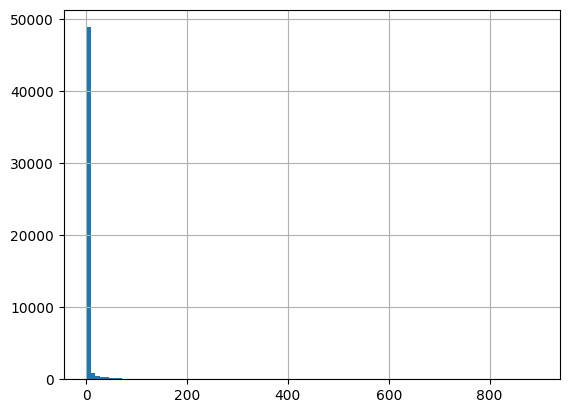

In [150]:
df_an.ntl_sum.hist(bins=100)